# Quantum Algorithms
### Objectives
1. Implement 4-qubit Quantum Fourier Transform circuit. Show the output of the circuit.
2. Implement the 4-qubit Inverse Quantum Fourier Transform (IQFT) using the circuit you implemented in Point 1.
3. Implement a Quantum Phase Estimation (QPE) for S-gate using 4-qubit precision (i.e. 4-qubits in the eiganvalue register). Use the IQFT circuit you implemented in Point 2. Compute the phase θ.

In [141]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from math import pi
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex



In [142]:
def run_on_simulation(qc, shots=1024):
#     simulator = Aer.get_backend('qasm_simulator')
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qc, simulator, shots=shots)

    return job.result()

def least_busy_backend(n_qubits):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n_qubits+1) and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    
    return backend


def run_on_IBMQ(qc, backend, shots=100):
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    job_monitor(job, interval=2)
    
    return job.result()


# 1. Implement 4-qubit Quantum Fourier Transform circuit
The following code implements a 4-qubit QFT circuit:
[ [the reference](https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform) ]

In [176]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

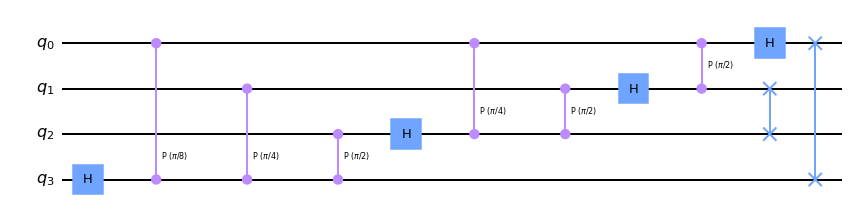

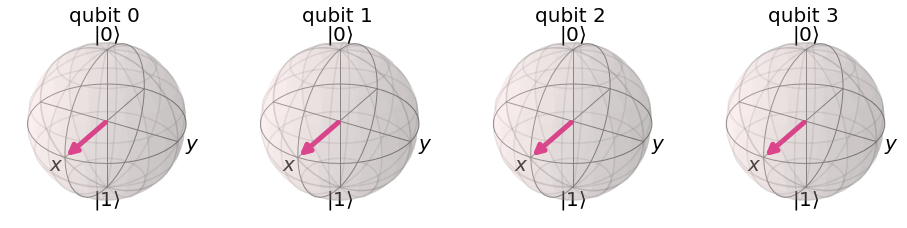

 - - - - - - - - - - - -[ AFTER MEASUREMENT ]- - - - - - - - - - - - 


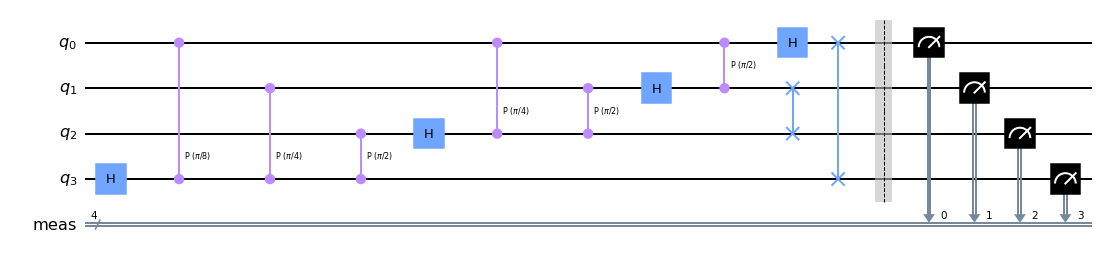

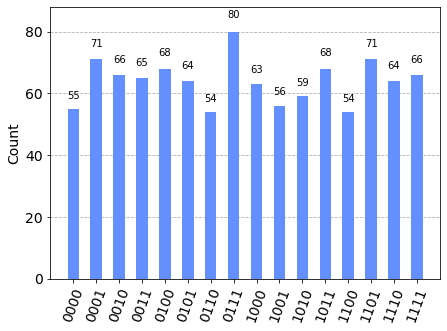

In [171]:
n=4
qc = QuantumCircuit(n)
qft = qft(qc, n)

display(qft.draw(output='mpl'))
result = run_on_simulation(qft)
display(plot_bloch_multivector(result.get_statevector()))

print(12*' -' + '[ AFTER MEASUREMENT ]' + 12*'- ')

qft.measure_all()
display(qft.draw(output='mpl'))
result = run_on_simulation(qft)
display(plot_histogram(result.get_counts()))

An alternative approach involves utilizing the built-in quantum Fourier transform (QFT) library in Qiskit by importing it with `from qiskit.circuit.library import QFT` and using `QFT(n)` to apply the transform.

## 2. Implement the 4-qubit Inverse Quantum Fourier Transform (IQFT)
The following code implements a 4-qubit IQFT circuit:
[ [the reference](https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform) ]

In [177]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

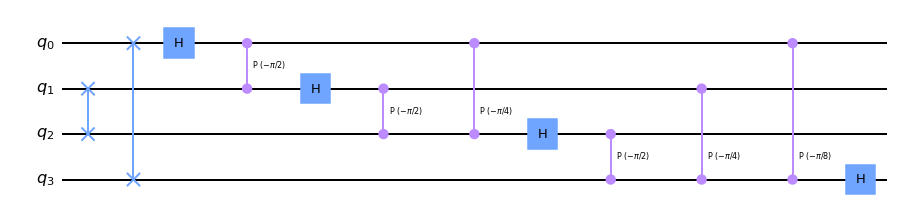

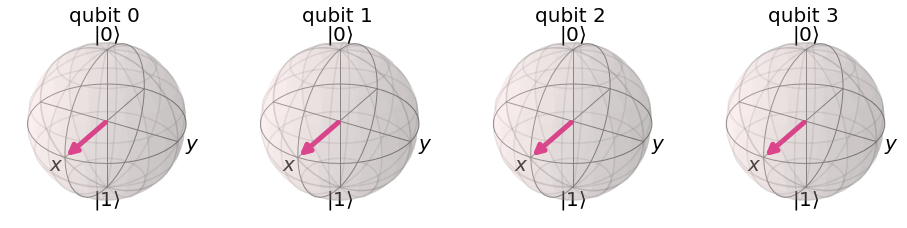

 - - - - - - - - - - - -[ AFTER MEASUREMENT ]- - - - - - - - - - - - 


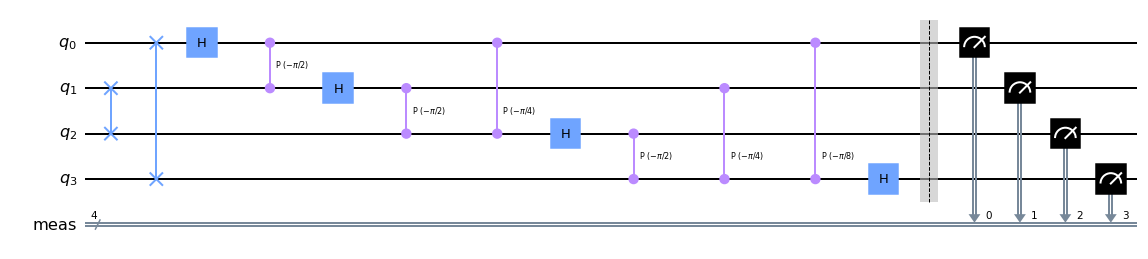

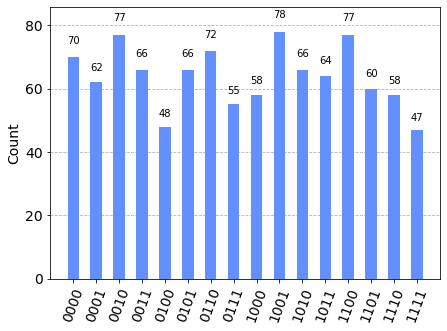

In [178]:
n=4
qc = QuantumCircuit(n)
iqft = inverse_qft(qc, n)

display(iqft.draw(output='mpl'))
result = run_on_simulation(iqft)
display(plot_bloch_multivector(result.get_statevector()))

print(12*' -' + '[ AFTER MEASUREMENT ]' + 12*'- ')

iqft.measure_all()
display(iqft.draw(output='mpl'))
result = run_on_simulation(iqft)
display(plot_histogram(result.get_counts()))

An alternative method involves utilizing the built-in quantum Fourier transform (QFT) library in Qiskit by importing it with `from qiskit.circuit.library import QFT` and setting the `inverse` parameter to `True` in `QFT(n, inverse=True)`.

## 3. Implement a Quantum Phase Estimation (QPE)
The following code implements a QPE for S-gate using 4-qubit precision:
[ [the reference](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation) ]

To create the $S$ operation. The phase gate does the transformation $ P|1\rangle = e^{i\lambda}|1\rangle $, where $ \lambda = \frac{\pi}{2} $.


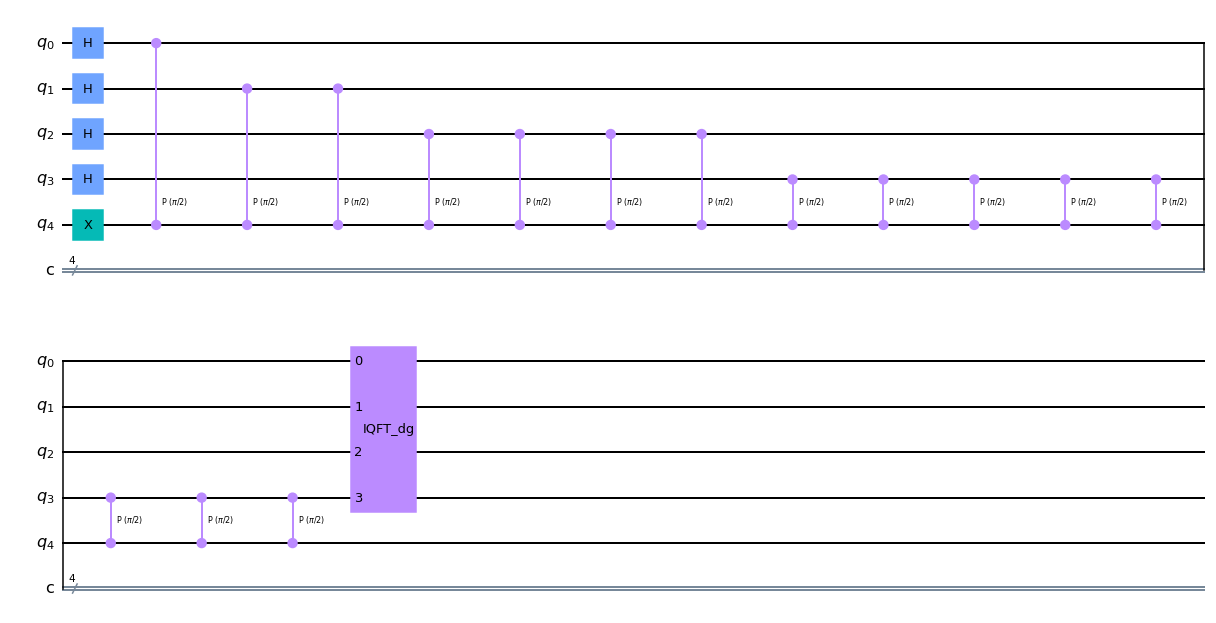

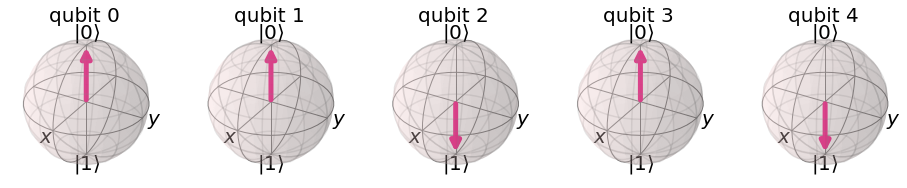

 - - - - - - - - - - - -[ AFTER MEASUREMENT ]- - - - - - - - - - - - 


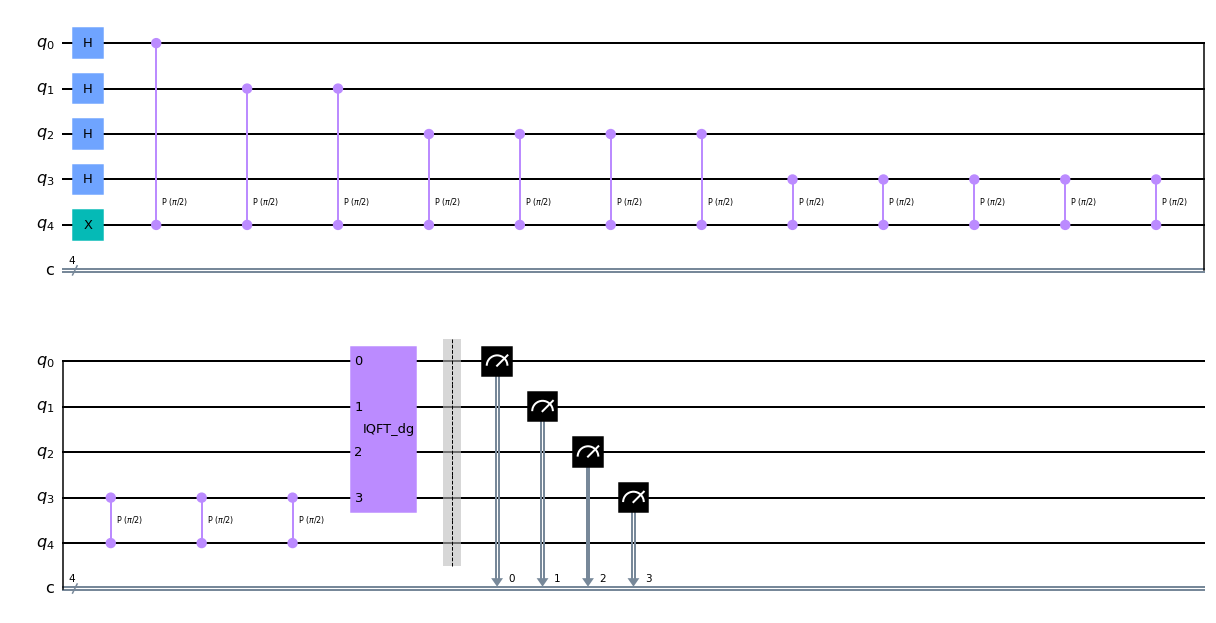

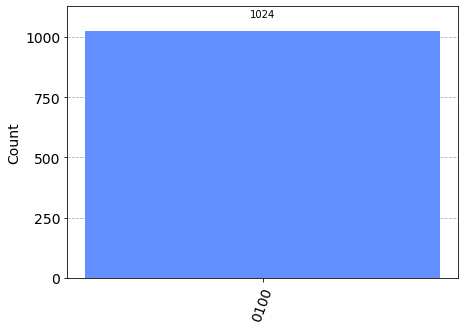

In [179]:
n = 4
qpe = QuantumCircuit(n+1, n)

for qubit in range(n):
    qpe.h(qubit)

qpe.x(n)

# angle = 2*pi/3
angle = pi/2 # controlled-S
repetitions = 1
for counting_qubit in range(n):
    for i in range(repetitions):
        qpe.cp(angle, counting_qubit, n);
    repetitions *= 2

qpe = qpe.compose(QFT(n, inverse=True), range(n))

display(qpe.draw(output='mpl'))
result = run_on_simulation(qpe)
display(plot_bloch_multivector(result.get_statevector()))

qpe.barrier()
for n in range(n):
    qpe.measure(n,n)

print(12*' -' + '[ AFTER MEASUREMENT ]' + 12*'- ')

display(qpe.draw(output='mpl'))
result = run_on_simulation(qpe)
display(plot_histogram(result.get_counts()))

We get one result (0100) with certainty, which translates to the decimal: 4. We now need to divide our result ($4$) by $2^n$ to get $\theta$

$$ \theta = \frac{4}{2^4} = \frac{1}{4} = 0.25 $$


> We are avoiding running the case on the real quantum machine due to the long processing time, which is estimated to complete in approximately two days.